# TODO
#### Clean NAN
- remove all NAN ratings (if any of rating1 or 2 is NAN)
- replace NAN values in other columns with a default value
    - height & weight with median
    - position with a new position (eg. 'Joker')
    - photoID (there is no NAN after removing the NAN ratings)
    - Alpha_3 with 'World'
    - *IAT and *Exp with 0 (we have no values therefore we assume no racial bias)
    
#### handling different ratings (rater1 vs rater2)
- there is no player with only one rating 
- and the ratings are consistent for each player (for one rater)
- what rating to take:
    - take the rating of the rater where less dissagreement happend. (rater2->0, rater1->1, rater2->2, rater2->3, rater1->4) so if rater2 rated 0 take it... (in order 4, 0, 1, 2, 3)
    - compare taking only rater1 vs rater2
    - make a colum 'color_rating' and remove the other two
    
#### Agregating the player
- explain why aggregating (not aggregating overfits on the player name etc.)
- aggregate
    - club: test if one player played for different clubs. -> one (several) hot encoding. or majority dyads per club
    - leagueCountry: same as club
    - position: test if different -> majority? 
    - photoID: ignore if different
    - refNum: replace with number of unique refs
    - refCountry: same as refNum
    - Alpha_3: remove
    - meanIAT: make new features
        - take mean 
        - take weighted mean (weight with nIAT)
        - take weighted mean (weight with game numers)
    - meanExp: same as IAT
    - seAIT: 
    - seExp: 

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import show

%matplotlib inline
sns.set_context('notebook')
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500) # to see all columns

In [2]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


Skincolor is rated by two persons (rater1 and rater2) on a 5 point scala (0 = verly light, 5 = very dark).
We have to know this values for the HW, therefore we remove all players that have no value in eiter rater1 or rater2.

Note that there is no player with only one rating and one player's ratings are consistent

In [3]:
# count how many players have different ratings from the same rater (should be 0)
consistent = 0
for pn in data['playerShort'].unique():
    player_data = data[data['playerShort'] == pn]
    if (len(player_data['rater1'].unique()) != 1 or len(player_data['rater2'].unique()) != 1):
        print(pn)
        consistent += 1
print("should be 0:", consistent)

# count how many players have only 1 rating (should be 0)
print("should be 0:", len(data[~pd.isnull(data['rater1'])][pd.isnull(data['rater2'])]) + len(data[pd.isnull(data['rater1'])][~pd.isnull(data['rater2'])]))

should be 0: 0
should be 0: 0


/home/lukas/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [4]:
# remove rows where skin color is nan
data = data[~pd.isnull(data['rater1'])]
data = data[~pd.isnull(data['rater2'])]

The two raters don't agree on all players what should we do? They dissagree for 23% of the players.

In [5]:
print("percentage of players with different ratings: ", len(data[data['rater1'] != data['rater2']])*100 / len(data), "%")

percentage of players with different ratings:  23.195930059941745 %


We have several options:
- just take one of the raters values (ignore the other) or compare the differences of the two
- take one at random for each player -> differs from execution to execution
- remove the ambiguous players -> drawback: removing almost 1/4 of the data
- expand to a 9 point system and take the average of the two ratings -> less data for the 'intermediate' points.

Some plots to show the situation.
Plot 3 and 4 show where the two raters disagreed most. Eg. 16'000 times the rater1 rated a player 0 but rater2 did not.
All in all we can see that rater1 perceived the white players lighter than rater2. For the dark players they agree better.
Most disagreement happens between category 0 and 0.25 and the disagreement is almost always only one category appart.
It does therefore not matter too much which rater to take, but it would be interesting if taking rater1 or 2 makes a difference for the ML part.

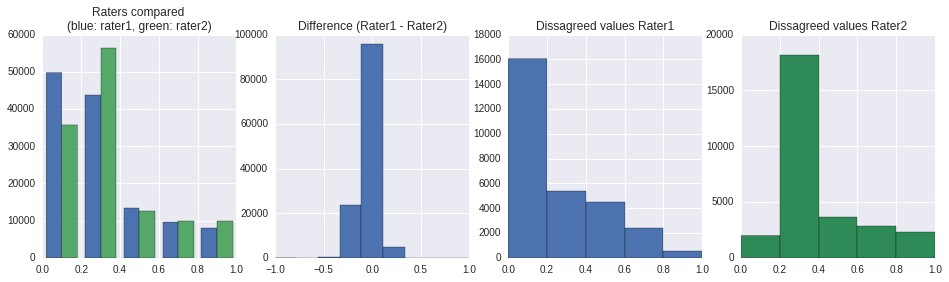

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].hist([data['rater1'], data['rater2']], bins=5)
ax[0].set_title("Raters compared \n(blue: rater1, green: rater2)")

ax[1].hist(data['rater1'] - data['rater2'], bins=9, range=(-1, 1))
ax[1].set_title("Difference (Rater1 - Rater2)")

dissagree_data = data[data['rater1'] != data['rater2']]
ax[2].hist(dissagree_data['rater1'], bins=5)
ax[2].set_title("Dissagreed values Rater1")

ax[3].hist(dissagree_data['rater2'], bins=5, color='seagreen')
ax[3].set_title("Dissagreed values Rater2")


In [7]:
# Create the rating column. We just take the rater1.
Rater = 'rater1'
data['color_rating'] = data.apply(lambda row: row[Rater], axis=1)
# drop the two ratings
data.drop('rater1', axis=1, inplace=True)
data.drop('rater2', axis=1, inplace=True)

Now we have to make the color_rating categorical

In [8]:
# make color_rating categorical
categorical_dict = {0: 'WW', 0.25: 'W', 0.5: 'N', 0.75: 'B', 1: 'BB' }
data['color_rating'] = data.apply(lambda row: categorical_dict[row['color_rating']]
, axis=1).astype('category')

In [9]:
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,color_rating
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,95212.jpg,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,W
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1663.jpg,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,B
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0,0,0,3868.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,W
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0,0,0,0,47704.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,WW
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0,0,0,0,22356.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,BB


# Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing as pp
from sklearn.model_selection import KFold , cross_val_score
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score

In [11]:
# encoders
le = pp.LabelEncoder() # for playernames etc.
ohe = pp.OneHotEncoder() # for categories with 'few' categories

Create the data for the RF

Turns out that there are some 'NaN' values. So we replace them with a default.

In [12]:
np.sum(pd.isnull(data))

playerShort         0
player              0
club                0
leagueCountry       0
birthday            0
height             46
weight            753
position         8461
games               0
victories           0
ties                0
defeats             0
goals               0
yellowCards         0
yellowReds          0
redCards            0
photoID             0
refNum              0
refCountry          0
Alpha_3             1
meanIAT           153
nIAT              153
seIAT             153
meanExp           153
nExp              153
seExp             153
color_rating        0
dtype: int64

In [13]:
data['position'] = data['position'].fillna(value="Joker") # all players with no position play the same position
data['Alpha_3'] = data['Alpha_3'].fillna(value="WO") # No country means they play for WOrld ;)

# replace no height and weight with the mean value
mean_height = np.mean(data['height'].dropna())
mean_weight = np.mean(data['weight'].dropna())
data['height'] = data['height'].fillna(value=mean_height)
data['weight'] = data['weight'].fillna(value=mean_weight)

# the IAT stuff, replace all with 0 (meaning no bias). 
data['meanIAT'] = data['meanIAT'].fillna(value=0)
data['nIAT'] = data['nIAT'].fillna(value=0)
data['seIAT'] = data['seIAT'].fillna(value=0)
data['meanExp'] = data['meanExp'].fillna(value=0)
data['nExp'] = data['nExp'].fillna(value=0)
data['seExp'] = data['seExp'].fillna(value=0)

In [14]:
np.sum(np.sum(pd.isnull(data)))

0

In [15]:
data['player_encoded'] = le.fit_transform(data['player'])
data['club_encoded'] = le.fit_transform(data['club'])
data['leagueCountry_encoded'] = le.fit_transform(data['leagueCountry'])
data['birthday_encoded'] = le.fit_transform(data['birthday'])
data['position_encoded'] = le.fit_transform(data['position'])
data['Alpha_3_encoded'] = le.fit_transform(data['Alpha_3'])
data['color_rating_encoded'] = le.fit_transform(data['color_rating'])

rf_input_data = data[['player_encoded', 'club_encoded', 'leagueCountry_encoded', \
                      'birthday_encoded', 'height', 'weight', 'position_encoded', \
                      'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', \
                      'yellowReds', 'redCards', 'refNum', 'refCountry', 'Alpha_3_encoded', \
                      'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'seExp']]
player_colors = data['color_rating_encoded']

rf_input_data.dtypes

player_encoded             int64
club_encoded               int64
leagueCountry_encoded      int64
birthday_encoded           int64
height                   float64
weight                   float64
position_encoded           int64
games                      int64
victories                  int64
ties                       int64
defeats                    int64
goals                      int64
yellowCards                int64
yellowReds                 int64
redCards                   int64
refNum                     int64
refCountry                 int64
Alpha_3_encoded            int64
meanIAT                  float64
nIAT                     float64
seIAT                    float64
meanExp                  float64
seExp                    float64
dtype: object

### Train and test the Random Forest with KFold cross validation

In [16]:
rf = RandomForestClassifier()
# roc_scorer = make_scorer(roc_curve)
X = rf_input_data
y = player_colors
result = cross_val_score(rf, X, y, cv=10, n_jobs=3, pre_dispatch='n_jobs+1', verbose=3)

"""
kf = KFold(n_splits=10)
for train, test in kf.split(rf_input_data):
    X_train, X_test, y_train, y_test = rf_input_data[train], rf_input_data[test], player_colors[train], player_colors[test]
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
"""

result

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................................... , score=0.983713 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=0.993421 -   0.1s
[CV]  ................................................................
[CV] ....................................... , score=0.992779 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=0.990933 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=0.997111 -   0.1s
[CV]  ................................................................
[CV] ....................................... , score=0.991574 -   0.0s
[CV]  

[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   10.2s finished


array([ 0.98371309,  0.99277862,  0.99342052,  0.99093316,  0.99711122,
        0.99157439,  0.99518536,  0.99671   ,  0.99269663,  0.96605136])

In [17]:
rf.fit(rf_input_data, player_colors)
imp_features = rf.feature_importances_
cols = rf_input_data.columns
for i in range(0, len(imp_features)):
    print(cols[i], " -> ", imp_features[i])

player_encoded  ->  0.175202264287
club_encoded  ->  0.146708429677
leagueCountry_encoded  ->  0.0403729804131
birthday_encoded  ->  0.164038619047
height  ->  0.133541784112
weight  ->  0.131751198068
position_encoded  ->  0.102987813246
games  ->  0.0088128590778
victories  ->  0.00734229157339
ties  ->  0.00447271013862
defeats  ->  0.00569158111539
goals  ->  0.00660599028286
yellowCards  ->  0.00400985444942
yellowReds  ->  0.000352150538138
redCards  ->  0.000369534006389
refNum  ->  0.0112139108117
refCountry  ->  0.00859648104073
Alpha_3_encoded  ->  0.00796698026516
meanIAT  ->  0.00717935402947
nIAT  ->  0.00712384398999
seIAT  ->  0.00730864328404
meanExp  ->  0.00977774857206
seExp  ->  0.00857297797418
